In [1]:

from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from PIL import Image, ImageFile
from PIL import ImageDraw
import datasets
from datasets import load_dataset
from torch.utils.data import random_split

In [2]:

class DoubleConv(nn.Module):
    def __init__(self, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LazyConv2d(out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(DoubleConv(feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1] * 2)

        # Decoder
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(DoubleConv(feature))  # after concatenation

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # upsample
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat((skip_connection, x), dim=1)  # concat
            x = self.decoder[idx + 1](x)  # double conv

        return self.final_conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128, features=[64, 128, 256, 512]):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.layers.append(DoubleConv(feature))

        self.flatten = nn.Flatten()
        self.fc_mu = nn.LazyLinear(latent_dim)
        self.fc_logvar = nn.LazyLinear(latent_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.pool(x)
        x = self.flatten(x)
        return self.fc_mu(x), self.fc_logvar(x)


# class Decoder(nn.Module):
#     def __init__(self, out_channels=1, latent_dim=128, hidden_dims=[512, 256, 128, 64]):
#         super(Decoder, self).__init__()
#         self.latent_dim = latent_dim

#         self.feature_map_shape = (hidden_dims[0], 4, 4)  # change if needed
#         num_flat_features = hidden_dims[0] * 4 * 4

#         self.fc = nn.Linear(latent_dim, num_flat_features)

#         modules = []
#         in_channels = hidden_dims[0]
#         for h_dim in hidden_dims[1:]:
#             modules.append(
#                 nn.Sequential(
#                     nn.ConvTranspose2d(in_channels, h_dim, kernel_size=4, stride=2, padding=1),
#                     nn.ReLU(inplace=True)
#                 )
#             )
#             in_channels = h_dim

#         self.decoder = nn.Sequential(*modules)

#         self.final_layer = nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid()  # assumes heightmap is normalized to [0, 1]
#         )

#     def forward(self, z):
#         x = self.fc(z)
#         x = x.view(x.size(0), *self.feature_map_shape)
#         x = self.decoder(x)
#         return self.final_layer(x)

class Decoder(nn.Module):
    def __init__(self, out_channels=3, latent_dim=128):
        super(Decoder, self).__init__()
        self.feature_map_shape = (512, 4, 4)  # Starting shape after FC layer
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  # 4 → 8
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8 → 16
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),  # 16 → 32
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32 → 64
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64 → 128
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),    # 128 → 256
            nn.ReLU(True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 256 → 512
            nn.Sigmoid()  # or Tanh(), depending on your input normalization
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), *self.feature_map_shape)
        x = self.decoder(x)
        return x

class ConvVAE(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, latent_dim=latent_dim)
        self.decoder = Decoder(out_channels=out_channels, latent_dim=latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        # print(f"recon shape: {recon.shape}, mu shape: {mu.shape}, logvar shape: {logvar.shape}")
        return recon, mu, logvar

Found 15000 files
First 5 files: ['2718_i2.png', '3184_t.png', '0080_i2.png', '2806_h.png', '0689_i2.png']
Found 5000 triplets in ./data/terrain_reconstruction/_dataset


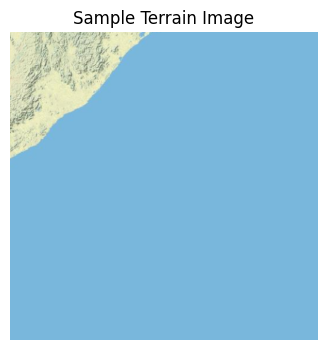

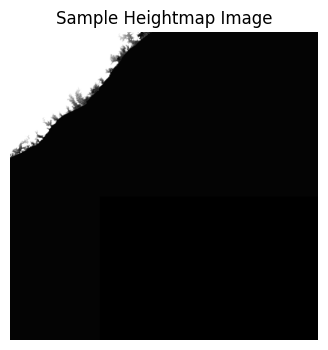

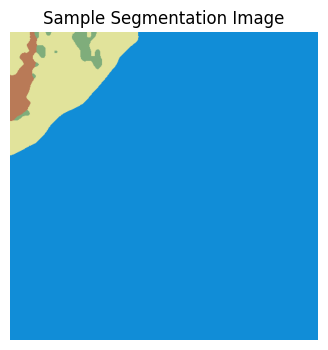

In [3]:
# Dataset path
dataset_path = './data/terrain_reconstruction/_dataset'

all_files = os.listdir(dataset_path)
print(f"Found {len(all_files)} files")
print("First 5 files:", all_files[:5])

# # Define dataset class
# class TerrainDataset(Dataset):
#     def __init__(self, data_dir, image_type, transform=None):
#         self.data_dir = data_dir
#         self.transform = transform
#         self.image_paths = [
#             os.path.join(data_dir, f) for f in os.listdir(data_dir) if image_type in f
#         ]
#         print(f"Found {len(self.image_paths)} '{image_type}' images in {data_dir}")
#         # self.labels = [
#         #     int(os.path.basename(f).split('_')[0]) for f in self.image_paths
#         # ]

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = Image.open(self.image_paths[idx]).convert('RGB')
#         # label = self.labels[idx]
#         if self.transform:
#             image = self.transform(image)
#         return image

# Define transform
transform_pipeline = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

# class TerrainDataset(Dataset):
#     def __init__(self, data_dir, transform=None):
#         self.data_dir = data_dir
#         self.transform = transform
#         self.image_types = ['h', 't', 'i']  # heightmap, terrain, segmentation
#         self.image_paths_height = [
#             os.path.join(data_dir, f) for f in os.listdir(data_dir) if 'h' in f
#         ]
#         self.image_paths_terrain = [
#             os.path.join(data_dir, f) for f in os.listdir(data_dir) if 't' in f
#         ]
#         self.image_paths_segmentation = [
#             os.path.join(data_dir, f) for f in os.listdir(data_dir) if 'i' in f
#         ]
#         self.image_paths = self.image_paths_height + self.image_paths_terrain + self.image_paths_segmentation
#         print(f"Found {len(self.image_paths)}  images in {data_dir}")

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         # image = Image.open(self.image_paths[idx]).convert('RGB')
#         # if self.transform:
#         #     image = self.transform(image)
#         # return image
#         images = []
#         for image_type in [self.image_paths_height, self.image_paths_terrain, self.image_paths_segmentation]:
#            image = Image.open(image_type[idx]).convert('RGB')
#            if self.transform:
#                image = self.transform(image)
#            images.append(image)
#         return images  # Return a tuple of (heightmap, terrain, segmentation) 
class TerrainDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # Sort to ensure alignment between h, t, i files
        self.height_paths = sorted(
            [os.path.join(data_dir, f) for f in os.listdir(data_dir) if '_h' in f]
        )
        self.terrain_paths = sorted(
            [os.path.join(data_dir, f) for f in os.listdir(data_dir) if '_t' in f]
        )
        self.segmentation_paths = sorted(
            [os.path.join(data_dir, f) for f in os.listdir(data_dir) if '_i' in f or '_i2' in f]
        )

        assert len(self.height_paths) == len(self.terrain_paths) == len(self.segmentation_paths), \
            "Mismatch in dataset triplet lengths"

        print(f"Found {len(self.height_paths)} triplets in {data_dir}")

    def __len__(self):
        return len(self.height_paths)

    def __getitem__(self, idx):
        # Load heightmap, terrain, segmentation
        paths = [self.height_paths[idx], self.terrain_paths[idx], self.segmentation_paths[idx]]
        images = []
        for path in paths:
            image = Image.open(path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            images.append(image)
        return tuple(images)  # (heightmap, terrain, segmentation)
# # Use the correct variable in dataset
# heightmap_dataset = TerrainDataset(dataset_path, 'h', transform=transform_pipeline)
# terrain_dataset = TerrainDataset(dataset_path, 't', transform=transform_pipeline)
# segmentation_dataset = TerrainDataset(dataset_path, 'i', transform=transform_pipeline)
dataset = TerrainDataset(dataset_path, transform=transform_pipeline)

# Example: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_test= random_split(dataset, [train_size, test_size])

# # Do the same for terrain and segmentation
# terrain_train, terrain_test = random_split(terrain_dataset, [train_size, test_size])
# segmentation_train, segmentation_test = random_split(segmentation_dataset, [train_size, test_size])


# Function to show a normalized image
def show_tensor_image(tensor_img, title=""):
    # De-normalize
    # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    # img = tensor_img * std + mean
    # img = img.permute(1, 2, 0).numpy()
    img = tensor_img.permute(1, 2, 0).numpy()  # Convert to HWC format
    
    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show sample image from terrain dataset
# print(len(dataset_train))
# image = next(iter(dataset_train))
# show_tensor_image(image, title="Sample Terrain Image")
sample = dataset_train[0]
heightmap, terrain, segmentation = sample  # unpack tuple

show_tensor_image(terrain, title="Sample Terrain Image")
show_tensor_image(heightmap, title="Sample Heightmap Image")
show_tensor_image(segmentation, title="Sample Segmentation Image")

In [4]:
# from unet import UNet
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

#initialize dataloaders
numworkers=16
batchsize =4
# heightmap_loader = DataLoader(heightmap_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
# terrain_loader = DataLoader(terrain_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
# # segmentation_loader = DataLoader(segmentation_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
# heightmap_train_loader = DataLoader(heightmap_train, batch_size=batchsize, shuffle=True, num_workers=numworkers)
# heightmap_test_loader = DataLoader(heightmap_test, batch_size=batchsize, shuffle=False, num_workers=numworkers)
# terrain_train_loader = DataLoader(terrain_train, batch_size=batchsize, shuffle=True, num_workers=numworkers)
# terrain_test_loader = DataLoader(terrain_test, batch_size=batchsize, shuffle=False, num_workers=numworkers)
# segmentation_train_loader = DataLoader(segmentation_train, batch_size=batchsize, shuffle=True, num_workers=numworkers)
# segmentation_test_loader = DataLoader(segmentation_test, batch_size=batchsize, shuffle=False, num_workers=numworkers)
train_loader = DataLoader(dataset_train, batch_size=batchsize, shuffle=True, num_workers=numworkers)
test_loader = DataLoader(dataset_test, batch_size=batchsize, shuffle=False, num_workers=numworkers)


# Initialize UNet model
# unet_model = UNet(in_channels=3, out_channels=3).to(device)
vae_model = ConvVAE(in_channels=3, out_channels=3, latent_dim=128).to(device)
# criterion = nn.MSELoss()
def vae_loss(recon, target, mu, logvar):
    recon_loss = F.mse_loss(recon, target, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = recon_loss + kl_div
    return loss, recon_loss, kl_div   # ✅ must return a tuple
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)


In [5]:
# num_epochs = 2
# for epoch in range(num_epochs):
#     vae_model.train()
#     running_loss = 0.0
    
#     for i, (images) in enumerate(train_loader):
#         images = images.to(device)
        
#         # Forward pass
#         outputs = vae_model(images)
#         loss = criterion(outputs, images)
#         running_loss += loss.item()
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         if (i + 1) % 10 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

num_epochs = 20
for epoch in range(num_epochs):
    vae_model.train()
    running_loss = 0.0
    recon_loss = 0.0
    kl_div = 0.0
    
    for i, (height, terrain, segmentation) in enumerate(train_loader):
        images = segmentation
        images = images.to(device)
        target_images = height
        target_images = target_images.to(device)
        
        # Forward pass
        # outputs = vae_model(images)
        recon, mu, logvar = vae_model(images)
        # loss = criterion(outputs, target_images)
        loss, recon_loss, kl_div = vae_loss(recon, target_images, mu, logvar)
        running_loss += loss.item()
        recon_loss += recon_loss.item()
        kl_div += kl_div.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

torch.save(vae_model.state_dict(), './models/terrain/heightmap_vae_model.pth')
print("Model saved to './models/terrain/heightmap_vae_model.pth'")

Epoch [1/20], Step [10/1000], Loss: 0.2192
Epoch [1/20], Step [20/1000], Loss: 0.2314
Epoch [1/20], Step [30/1000], Loss: 0.2192
Epoch [1/20], Step [40/1000], Loss: 0.2794
Epoch [1/20], Step [50/1000], Loss: 0.2199
Epoch [1/20], Step [60/1000], Loss: 0.2307
Epoch [1/20], Step [70/1000], Loss: 0.2434
Epoch [1/20], Step [80/1000], Loss: 0.2009
Epoch [1/20], Step [90/1000], Loss: 0.1905
Epoch [1/20], Step [100/1000], Loss: 0.2032
Epoch [1/20], Step [110/1000], Loss: 0.3095
Epoch [1/20], Step [120/1000], Loss: 0.0852
Epoch [1/20], Step [130/1000], Loss: 0.2638
Epoch [1/20], Step [140/1000], Loss: 0.2322
Epoch [1/20], Step [150/1000], Loss: 0.1801
Epoch [1/20], Step [160/1000], Loss: 0.2304
Epoch [1/20], Step [170/1000], Loss: 0.1469
Epoch [1/20], Step [180/1000], Loss: 0.2666
Epoch [1/20], Step [190/1000], Loss: 0.3472
Epoch [1/20], Step [200/1000], Loss: 0.1716
Epoch [1/20], Step [210/1000], Loss: 0.2026
Epoch [1/20], Step [220/1000], Loss: 0.1868
Epoch [1/20], Step [230/1000], Loss: 0.12

KeyboardInterrupt: 

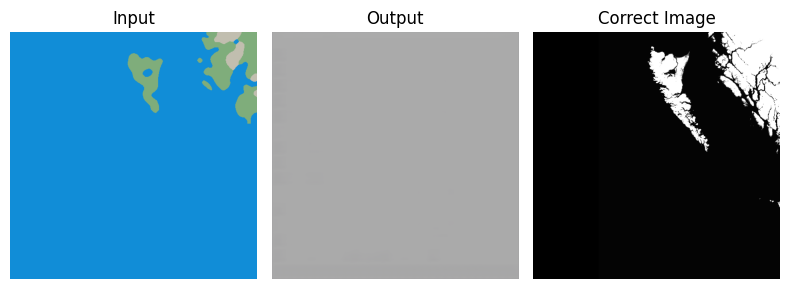

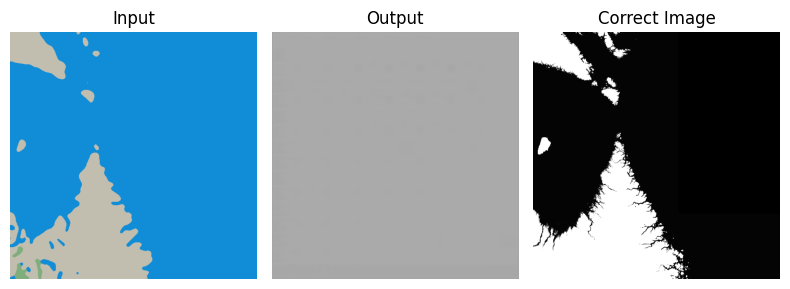

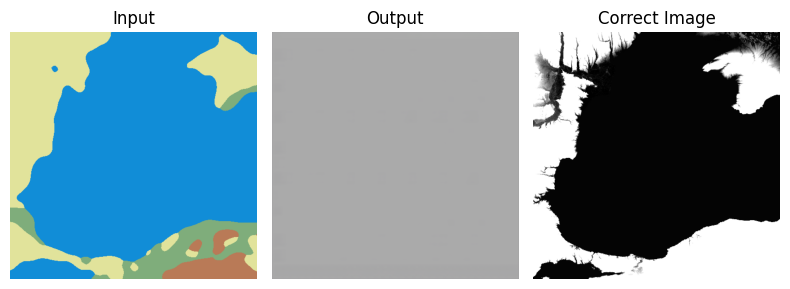

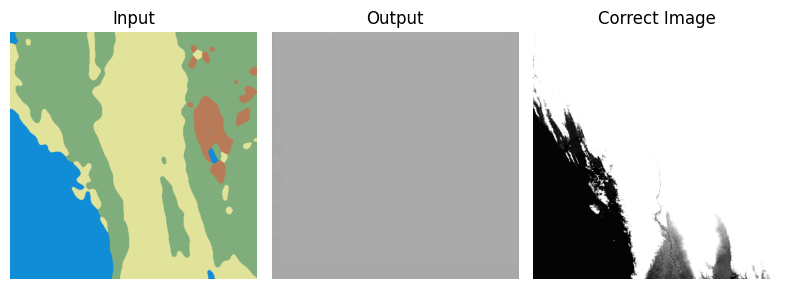

In [ ]:
def test_model(model, dataloader, device, save_output=False, output_dir='test_outputs'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        for idx, (height, terrain, segmentation) in enumerate(dataloader):
            images = segmentation
            correct_image = height  # Use heightmap as the correct image
            images = images.to(device)

            outputs, _, _ = model(images)
            outputs= torch.sigmoid(outputs)

            # If using sigmoid or BCE/MSE outputs
            # outputs = torch.sigmoid(outputs)
            # Move to CPU and convert to numpy
            inputs_np = images.cpu().permute(0, 2, 3, 1).numpy()
            outputs_np = outputs.cpu().permute(0, 2, 3, 1).clamp(0,1).numpy()
            correct_image_np = correct_image.cpu().permute(0, 2, 3, 1).numpy()

            for i in range(min(8, images.size(0))):  # Show/save up to 4 samples
                fig, axs = plt.subplots(1, 3, figsize=(8, 4))
                axs[0].imshow(inputs_np[i])
                axs[0].set_title("Input")
                axs[1].imshow(outputs_np[i])
                axs[1].set_title("Output")
                axs[2].imshow(correct_image_np[i])
                axs[2].set_title("Correct Image")
                for ax in axs:
                    ax.axis("off")
                plt.tight_layout()

                if save_output:
                    plt.savefig(f"{output_dir}/sample_{idx}_{i}.png")
                    plt.close()
                else:
                    plt.show()
            
            break  # only first batch for quick test
        
test_model(vae_model,test_loader, device)

In [ ]:
import cv2
import numpy as np

def get_model_predictions_cv2(model, dataloader, device, max_batches=1, index=0):
    """
    Returns input and output image batches from model evaluation (first N batches),
    converted to OpenCV BGR image arrays.

    Returns:
        List of tuples: [(input_cv2_image, output_cv2_image), ...]
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for count, (_, _, segmentation) in enumerate(dataloader):
            if(count < index):
                continue
            inputs = segmentation.to(device)

            outputs, _,_ = model(inputs)
            outputs = torch.sigmoid(outputs)  # if using BCE/MSE

            # Move tensors to CPU and convert to [H, W, C] NumPy format
            inputs_np = inputs.detach().cpu().permute(0, 2, 3, 1).clamp(0, 1).numpy()
            outputs_np = outputs.detach().cpu().permute(0, 2, 3, 1).clamp(0, 1).numpy()

            # Convert each image to OpenCV (BGR, uint8)
            for inp, out in zip(inputs_np, outputs_np):
                inp_bgr = cv2.cvtColor((inp * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                out_bgr = cv2.cvtColor((out * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                predictions.append((inp_bgr, out_bgr))

            if max_batches is not None:
                max_batches -= 1
                if max_batches <= 0:
                    break

    return predictions

got 4 predictions


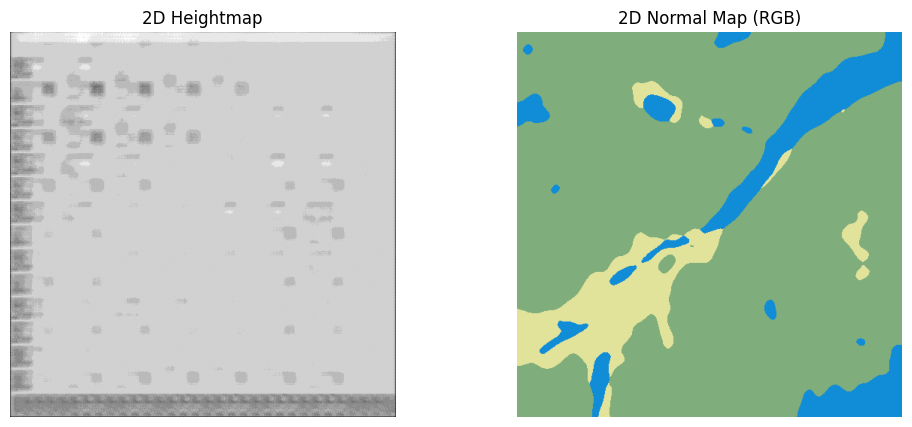

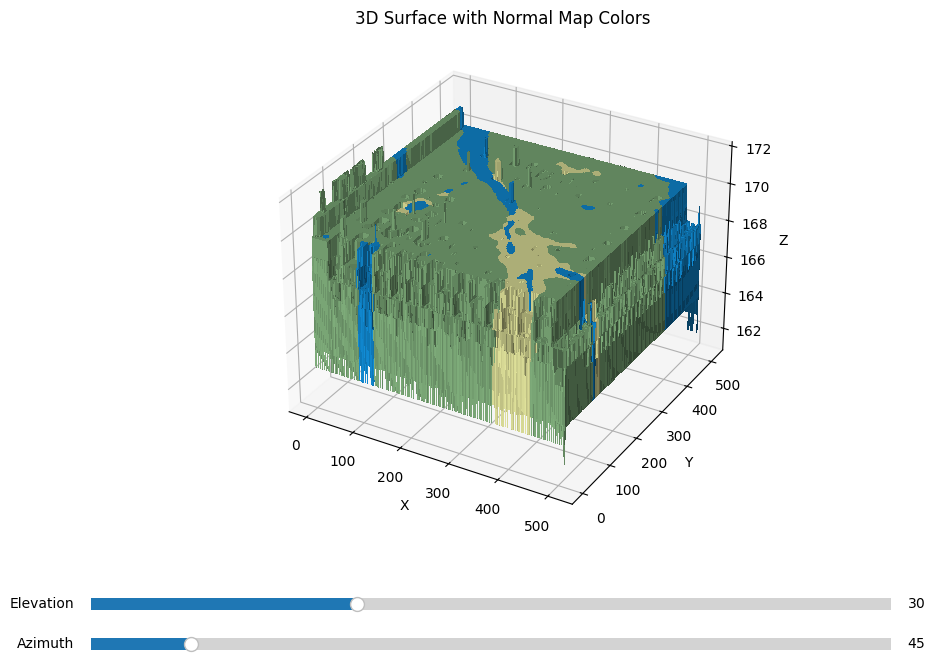

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider


predictions = get_model_predictions_cv2(vae_model, test_loader, device, max_batches=1, index=1)
print(f"got {len(predictions)} predictions")
input_img, output_img = predictions[0]  # Get first batch input and output
# Read heightmap (grayscale) and normal map images
# heightmap = cv2.imread('path_to_heightmap.png', 0)
# normal_map = cv2.imread('path_to_normal_map.png')
# Assume you’ve obtained heightmap and normal_map from your model
heightmap = output_img
normal_map = input_img

# Convert heightmap to grayscale if it's in BGR
if len(heightmap.shape) == 3:
    heightmap_gray = cv2.cvtColor(heightmap, cv2.COLOR_BGR2GRAY)
else:
    heightmap_gray = heightmap

# Convert normal map BGR → RGB (for correct colors in matplotlib)
normal_map_rgb = cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB)

# Show the images for verification
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(heightmap_gray, cmap='gray')
plt.title("2D Heightmap")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(normal_map_rgb)
plt.title("2D Normal Map (RGB)")
plt.axis("off")
plt.show()

# Prepare for 3D plotting
rows, cols = heightmap_gray.shape

# Create coordinate grids
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
Z = heightmap_gray.astype(np.float32)

# Transpose all for correct alignment if needed
Z = Z.T
normal_map_facecolors = normal_map_rgb.transpose(1, 0, 2) / 255.0  # Normalize and transpose to match Z

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(bottom=0.25)  # Add extra space at the bottom for sliders

ax_elev = plt.axes([0.1, 0.15, 0.8, 0.03])
ax_azim = plt.axes([0.1, 0.1, 0.8, 0.03])
slider_elev = Slider(ax_elev, 'Elevation', valmin=0, valmax=90, valinit=30)
slider_azim = Slider(ax_azim, 'Azimuth', valmin=0, valmax=360, valinit=45)
def update():
    elev = slider_elev.val
    azim = slider_azim.val
    ax.view_init(elev=elev, azim=azim)
    fig.canvas.draw_idle()

slider_elev.on_changed(update)
slider_azim.on_changed(update)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=normal_map_facecolors, rstride=1, cstride=1, linewidth=0, antialiased=False)
# ax.mouse_init(rotate_btn=None, zoom_btn=None) 
# ax.view_init(elev=30, azim=45)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# plt.title("3D Surface with Normal Map Colors")
ax.set_title("3D Surface with Normal Map Colors")

# Add sliders
# Update function

plt.show()
# Convert heightmap to grayscale if not already